# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

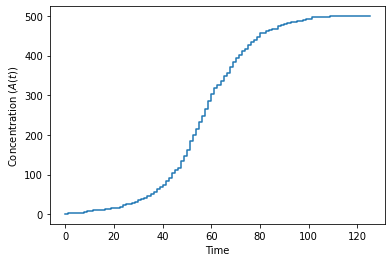

In [2]:
n_0 = 1
model = pints.toy.stochastic.LogisticModel(n_0)

times = np.linspace(0, 125, 101)

# $b_0$ = 0.1, $k$ = 500
params = [0.1, 500]

values = model.simulate(params, times)
problem = pints.SingleOutputProblem(model, times, values)
error_measure = pints.RootMeanSquaredError(problem)

log_prior = pints.UniformLogPrior([0.0, 400], [0.3, 700])

plt.step(times, values)
plt.xlabel('Time')
plt.ylabel(r'Concentration ($A(t)$)')
plt.show()

# Rejection ABC

In [16]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(30)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     35     0.0285714286     0:00.2
2     39     0.0512820513     0:00.2
3     41     0.0731707317     0:00.2
20    1133   0.0176522507     0:05.2
40    2181   0.0183402109     0:10.0
60    3402   0.0176366843     0:15.5
80    4552   0.0175746924     0:20.7
100   5586   0.0179018976     0:25.5
120   6945   0.0172786177     0:31.6
140   8691   0.0161086181     0:39.2
160   9867   0.0162156684     0:44.4
180   11419  0.0157632017     0:51.3
200   12979  0.0154095077     0:58.1
220   13869  0.0158627154     1:02.0
240   15416  0.0155682408     1:08.7
260   16715  0.0155548908     1:14.4
280   18130  0.0154440154     1:20.9
300   19437  0.0154344806     1:26.6
320   20656  0.0154918668     1:32.5
340   21882  0.015537885      1:37.7
360   23504  0.0153165419     1:44.8
380   25322  0.0150067135     1:52.8
400   26326  0.0151941047     1:57.1
420   27528  0.0152571927     2:02.5
440   29925  0.0

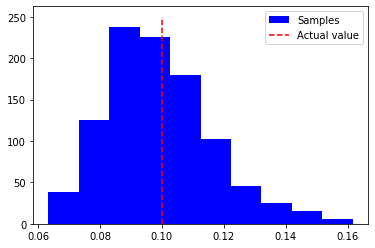

In [19]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

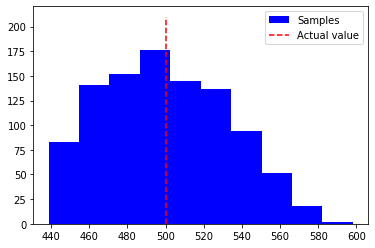

In [22]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=210, label="Actual value", color="red")
plt.legend()
plt.show()

# PMC

In [4]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set the threshold
abc.sampler().set_threshold(40)

# set target number of samples
# try this
abc.set_n_samples(1000)

# setting the number of generations
abc.sampler().set_n_generations(10)

# setting the threshold ratio
abc.sampler().set_t_ratio(0.99)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using PMC ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     81936  0.0122168522    32:48.9
Halting: target number of samples (1001) reached.
Done


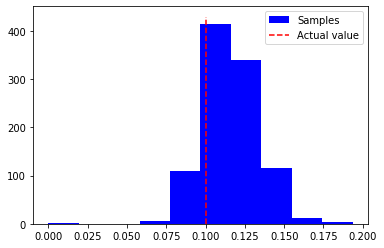

In [8]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=430, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

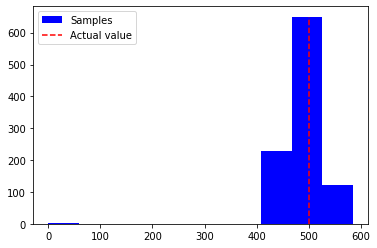

In [7]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=650, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# ABC SMC

In [43]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([50, 40, 30]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=40
Trying t=2, threshold=30
Iter. Eval. Acceptance rate Time m:s
1     5498   0.000181884322   0:27.4
2     5503   0.000363438125   0:27.4
3     5506   0.000544860153   0:27.4
20    5575   0.00358744395    0:27.8
40    5757   0.00694806323    0:28.6
60    5905   0.0101608806     0:29.3
80    6066   0.0131882624     0:30.1
100   6192   0.0161498708     0:30.7
120   6303   0.0190385531     0:31.2
140   6437   0.0217492621     0:31.9
160   6561   0.0243865264     0:32.4
180   6722   0.0267777447     0:33.2
200   6905   0.0289645185     0:34.0
220   7114   0.0309249367     0:34.8
240   7302   0.0328677075     0:35.7
260   7458   0.0348618933     0:36.4
280   7655   0.0365774004     0:37.3
300   7824   0.0383435583     0:38.1
320   8016   0.0399201597     0:39.0
340   8179   0.0415698741     0:39.7
360   8400   0.0428571429     0:40.7
380   8548   0.0444548432     0:41.4
400   8730   0.0458190149     0:42.3
420   8879   0.04730

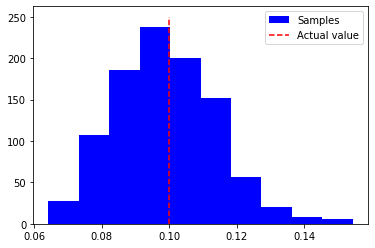

In [45]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

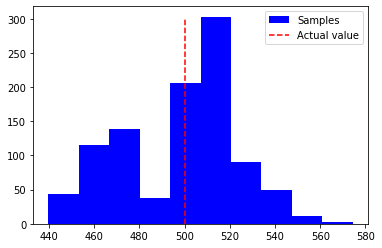

In [47]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()